In [1]:
from ast import Continue
from numpy.core.multiarray import empty
import numpy as np
import random


def board_printer(b):
    # Verify if the vector has the correct size
    if len(b) != 9:
        print("Invalid board size!")
        return

    c=[]
    for i in range(9):
      if b[i]!='E':
        if b[i]=='X':
          c.append('X')
        else:
          c.append('O')
      else:
        c.append(' ')

    # Print the Tic Tac Toe board
    print(" " + c[0] + " | " + c[1] + " | " + c[2] + " ")
    print("---+---+---")
    print(" " + c[3] + " | " + c[4] + " | " + c[5] + " ")
    print("---+---+---")
    print(" " + c[6] + " | " + c[7] + " | " + c[8] + " ")

def check_win(board):
    # Define all possible winning combinations
    winning_combinations = [
        [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
        [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
        [0, 4, 8], [2, 4, 6]               # Diagonals
    ]

    # Check if any player has won
    for combination in winning_combinations:
        if board[combination[0]] == board[combination[1]] == board[combination[2]] != 'E':
            return board[combination[0]]  # Return the winning player ('X' or 'O')

    # Check if the board is full (draw)
    if 'E' not in board:
        return 'Draw'

    # If no player has won and the board is not full, continue the game
    return 'Continue'


def next_turn(turn):
  #Gets a turn and returns its erverse
  if turn=='X':
    return 'O'
  else:
    return 'X'

def A(board,action):
  #Checks if an action is possible and legal on a board
  if board[action]!='E':
    return False

  if check_win(board)!= 'Continue':
    return False

  return True

def reward(board):
  #rewards +1 if X wins, -1 if O wins and 0 otherwise
  if  check_win(board)=='X':
    return 1
  elif check_win(board)=='O':
    return -1
  else:
    return 0


def next_state_same(board,turn,action):
  #Gets a board, an action indice and a turn and returns a new board with that player's mark in that action
  new_board=[]

  for i in range(9):
    if i==action:
      new_board.append(turn)
    else:
      new_board.append(board[i])

  return new_board

def next_state_reverse(board,turn,action):
  #Gets a board, an action indice and a turn and returns a new board with that player's opposite mark in that action

  new_turn=next_turn(turn)
  new_board=[]

  for i in range(9):
    if i==action:
      new_board.append(new_turn)
    else:
      new_board.append(board[i])

  return new_board






import itertools


def generate_vectors():
  #Generates all possible board states
    elements = ['X', 'O', 'E']
    vectors = []

    for combination in itertools.product(elements, repeat=9):
        vectors.append(list(combination))

    return vectors




def initial_v(states):
  #Assigns initial value of 0 to all states
    v_dict = {}
    turns = {'X', 'O'}
    for s in states:
        for t in turns:
          v_dict[tuple(s),t]=0

    return v_dict


def initial_a(states):
  #Implements a greedy policy for winning if winning in one step is possible and otherwise just chooses the first empty square it can find
  a_dict={}
  turns=['X','O']
  for s in states:
    for t in turns:
     for i in range(9):
        if s[i]=='E':
         a_dict[tuple(s),t]=i
         break

  for s in states:
    for t in turns:
      for i in range(9):
        if check_win(next_state_same(s,t,i))==t:
          a_dict[tuple(s),t]=i

  return a_dict


def v(board,turn,danger_p,calculated_v,best_actions):
  #Implements the Bellman equation
  best_action_max=-1
  best_action_min=-1
  max = float('-inf')
  min= float('inf')
  actionable=False
  candidate=0

  new_v= calculated_v.copy()
  new_ba= best_actions.copy()

  for action in range(9):
    if A(board,action) and check_win(board)=='Continue':

      candidate=  (   danger_p[action]*(reward(next_state_reverse(board,turn,action))+calculated_v[tuple(next_state_reverse(board,turn,action)),next_turn(turn)]) +
                      (1-danger_p[action])*(reward(next_state_same(board,turn,action))+calculated_v[tuple(next_state_same(board,turn,action)),next_turn(turn)])    )
      actionable=True

    if candidate>max and A(board,action) and check_win(board)=='Continue':
      max=candidate
      best_action_max= action

    if candidate < min and A(board,action) and check_win(board)=='Continue':
      min=candidate
      best_action_min=action



  if turn=='X'and actionable and check_win(board)=='Continue':
    new_v[tuple(board),turn]=max
    new_ba[tuple(board),turn]=best_action_max
  if turn=='O' and actionable and check_win(board)=='Continue':
    new_v[tuple(board),turn]=min
    new_ba[tuple(board),turn]=best_action_min

  return new_v,new_ba


states= generate_vectors()

In [6]:
Stochastic_P=[0.9, 0.3, 0.5, 0.2, 0.95, 0.7, 0.6, 0.45, 0.1]

Classic_P= [0,0,0,0,0,0,0,0,0]

Reverse_P=[1,1,1,1,1,1,1,1,1]

Noisy_reverse_P=[1,1,1,1,1,1,1,1,1]
for i in range(9):
  temp=random.random()*0.1
  Noisy_reverse_P[i]-=temp

Noisy_classic_P= [0,0,0,0,0,0,0,0,0]
for i in range(9):
  temp=random.random()*0.1
  Noisy_classic_P[i]+=temp

Half_P=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

totally_random=[]
for i in range(9):
  totally_random.append(random.random())

In [3]:
def find_value_function(P, name,iterations,states):


  cv=initial_v(states)
  ba=initial_a(states)

  for i in range(iterations):
    old_v=cv.copy()
    old_ba=ba.copy()
    diff={}
    for s in states:
      for t in ['X','O']:
        if check_win(s)=='Continue':
          temp_cv,temp_ba= v(s,t,P,old_v,old_ba)
          cv[tuple(s),t]= temp_cv[tuple(s),t]
          ba[tuple(s),t]=temp_ba[tuple(s),t]
          diff[tuple(s),t]= abs(cv[tuple(s),t]-old_v[tuple(s),t])
    print("\n\nmax diff:")
    print(max(diff.values()))
    print("max diff state:")
    print(max(diff, key=lambda k: diff[k]))
    print("average diff: ")
    print(sum(diff.values()) / len(diff.values()))

  import sys


  # Open the file in write mode
  with open(name, "w") as file:
      for s in states:
          for t in ['X', 'O']:
              if check_win(s) == 'Continue':
                  # Print the output of board_printer to the file
                  old_stdout = sys.stdout
                  sys.stdout = file  # Redirect stdout to the file
                  board_printer(s)
                  sys.stdout = old_stdout  # Restore stdout

                  # Redirect print statements to the file
                  print("turn=", file=file)
                  print(t, file=file)
                  print("value= ", file=file)
                  print(cv[tuple(s), t], file=file)
                  print("action= ", file=file)
                  print(ba[tuple(s), t] + 1, file=file)



                  # Print a separator in the file
                  print("-" * 20, file=file)

  return ba

In [4]:
stochastic_ba=find_value_function(Stochastic_P,'Stochastic.txt',10,states)



max diff:
0.95
max diff state:
(('X', 'X', 'O', 'O', 'E', 'X', 'X', 'X', 'O'), 'O')
average diff: 
0.29935094203553664


max diff:
0.8999999999999999
max diff state:
(('X', 'X', 'O', 'X', 'E', 'X', 'O', 'X', 'E'), 'X')
average diff: 
0.18552375371856858


max diff:
0.8999999999999999
max diff state:
(('X', 'X', 'O', 'X', 'E', 'E', 'O', 'E', 'X'), 'X')
average diff: 
0.12448458487334439


max diff:
0.8999999999999999
max diff state:
(('X', 'X', 'O', 'E', 'E', 'E', 'O', 'E', 'X'), 'X')
average diff: 
0.08418015865861354


max diff:
0.8999999999999999
max diff state:
(('X', 'E', 'O', 'E', 'E', 'E', 'O', 'E', 'X'), 'X')
average diff: 
0.03923012507887873


max diff:
0.8202119999999999
max diff state:
(('X', 'E', 'O', 'E', 'E', 'E', 'O', 'E', 'E'), 'X')
average diff: 
0.013901889434778688


max diff:
0.7528356
max diff state:
(('E', 'E', 'X', 'E', 'E', 'E', 'X', 'E', 'E'), 'O')
average diff: 
0.0031635938564860736


max diff:
0.37447880000000006
max diff state:
(('X', 'E', 'E', 'E', 'E', 

In [5]:
classic_ba=find_value_function(Classic_P,'Classic.txt',10,states)



max diff:
1
max diff state:
(('X', 'X', 'O', 'X', 'X', 'O', 'O', 'O', 'E'), 'X')
average diff: 
0.5936175966825926


max diff:
1
max diff state:
(('X', 'X', 'O', 'X', 'X', 'E', 'O', 'E', 'E'), 'O')
average diff: 
0.1732624177409177


max diff:
1
max diff state:
(('X', 'X', 'O', 'X', 'E', 'E', 'O', 'E', 'E'), 'X')
average diff: 
0.06373388623456233


max diff:
1
max diff state:
(('X', 'X', 'O', 'X', 'E', 'E', 'E', 'E', 'E'), 'O')
average diff: 
0.034977012530424595


max diff:
1
max diff state:
(('X', 'X', 'O', 'E', 'E', 'E', 'E', 'E', 'E'), 'O')
average diff: 
0.011989542955016677


max diff:
1
max diff state:
(('E', 'X', 'E', 'E', 'E', 'E', 'E', 'X', 'E'), 'O')
average diff: 
0.00018029387902280717


max diff:
0
max diff state:
(('X', 'X', 'O', 'X', 'X', 'O', 'O', 'O', 'E'), 'X')
average diff: 
0.0


max diff:
0
max diff state:
(('X', 'X', 'O', 'X', 'X', 'O', 'O', 'O', 'E'), 'X')
average diff: 
0.0


max diff:
0
max diff state:
(('X', 'X', 'O', 'X', 'X', 'O', 'O', 'O', 'E'), 'X')
av

In [7]:
reverse_ba=find_value_function(Reverse_P,'Reverse.txt',10,states)



max diff:
1
max diff state:
(('X', 'X', 'O', 'X', 'X', 'O', 'O', 'O', 'E'), 'X')
average diff: 
0.10150545388984045


max diff:
1
max diff state:
(('X', 'X', 'O', 'X', 'X', 'O', 'O', 'E', 'E'), 'X')
average diff: 
0.19219327503831246


max diff:
1
max diff state:
(('X', 'X', 'O', 'X', 'O', 'X', 'E', 'E', 'E'), 'X')
average diff: 
0.2363652753989002


max diff:
1
max diff state:
(('X', 'X', 'O', 'X', 'O', 'E', 'E', 'E', 'E'), 'X')
average diff: 
0.16929595240241593


max diff:
1
max diff state:
(('X', 'X', 'O', 'X', 'E', 'E', 'E', 'E', 'E'), 'O')
average diff: 
0.08185342107635446


max diff:
1
max diff state:
(('X', 'X', 'E', 'O', 'E', 'E', 'E', 'E', 'E'), 'X')
average diff: 
0.026503200216352656


max diff:
1
max diff state:
(('X', 'X', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 'O')
average diff: 
0.005679257189218426


max diff:
1
max diff state:
(('X', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 'X')
average diff: 
0.0007211755160912287


max diff:
0
max diff state:
(('X', 'X', 'O', 'X', '

In [8]:
noisy_classic_ba=find_value_function(Noisy_classic_P,'NoisyClassic.txt',10,states)



max diff:
0.97835282874629
max diff state:
(('X', 'E', 'X', 'X', 'X', 'O', 'O', 'X', 'O'), 'X')
average diff: 
0.5455846093997105


max diff:
0.9516516230333547
max diff state:
(('X', 'E', 'X', 'O', 'E', 'E', 'X', 'E', 'X'), 'O')
average diff: 
0.1806890850808327


max diff:
0.9182509988747867
max diff state:
(('X', 'E', 'E', 'O', 'O', 'X', 'E', 'E', 'O'), 'O')
average diff: 
0.06586634246344628


max diff:
0.8666028412850458
max diff state:
(('X', 'E', 'E', 'E', 'X', 'E', 'E', 'X', 'O'), 'O')
average diff: 
0.035359322098469856


max diff:
0.77542392417631
max diff state:
(('E', 'E', 'E', 'X', 'O', 'E', 'E', 'E', 'E'), 'O')
average diff: 
0.011168451138862228


max diff:
0.649545435850742
max diff state:
(('E', 'E', 'E', 'X', 'E', 'X', 'E', 'E', 'E'), 'O')
average diff: 
0.0015627781535205395


max diff:
0.08630418691068889
max diff state:
(('E', 'X', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 'O')
average diff: 
0.0002030452464049439


max diff:
0.04450465696338759
max diff state:
(('E', 

In [12]:
noisy_reverse_ba=find_value_function(Noisy_reverse_P,'NoisyReverse.txt',10,states)



max diff:
0.9972062748958397
max diff state:
(('X', 'X', 'O', 'E', 'X', 'X', 'X', 'O', 'O'), 'O')
average diff: 
0.12025478384246664


max diff:
0.9944125497916794
max diff state:
(('X', 'X', 'O', 'E', 'O', 'X', 'X', 'O', 'E'), 'X')
average diff: 
0.19290308771526116


max diff:
0.9829919145606852
max diff state:
(('X', 'E', 'O', 'E', 'X', 'X', 'X', 'E', 'O'), 'O')
average diff: 
0.21179213888663762


max diff:
0.9513498338513936
max diff state:
(('X', 'E', 'O', 'E', 'E', 'X', 'X', 'E', 'O'), 'X')
average diff: 
0.14893726186625558


max diff:
0.9372838866793592
max diff state:
(('X', 'E', 'E', 'E', 'E', 'X', 'X', 'E', 'O'), 'O')
average diff: 
0.07165545461944514


max diff:
0.8820175642639326
max diff state:
(('X', 'E', 'E', 'E', 'E', 'E', 'X', 'E', 'O'), 'X')
average diff: 
0.023012067397847624


max diff:
0.8220661507400945
max diff state:
(('X', 'E', 'E', 'E', 'E', 'E', 'X', 'E', 'E'), 'O')
average diff: 
0.005129609462935737


max diff:
0.7453938805323367
max diff state:
(('E',

In [25]:
half_ba=find_value_function(Half_P,'Half.txt',10,states)



max diff:
0.5
max diff state:
(('X', 'X', 'O', 'X', 'X', 'O', 'O', 'E', 'E'), 'X')
average diff: 
0.2518254755251059


max diff:
0.5
max diff state:
(('X', 'X', 'O', 'X', 'E', 'X', 'E', 'X', 'E'), 'O')
average diff: 
0.17862616064184622


max diff:
0.375
max diff state:
(('X', 'X', 'O', 'O', 'E', 'E', 'E', 'O', 'E'), 'O')
average diff: 
0.06736230054989634


max diff:
0.375
max diff state:
(('E', 'X', 'E', 'X', 'E', 'E', 'E', 'E', 'E'), 'O')
average diff: 
0.032576850265933474


max diff:
0.25
max diff state:
(('X', 'E', 'E', 'E', 'E', 'X', 'E', 'E', 'E'), 'X')
average diff: 
0.007907576850265934


max diff:
0.171875
max diff state:
(('X', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 'O')
average diff: 
0.0020480257820247004


max diff:
0.078125
max diff state:
(('E', 'E', 'E', 'E', 'X', 'E', 'E', 'E', 'E'), 'X')
average diff: 
0.00021269043540971783


max diff:
0.0390625
max diff state:
(('E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 'X')
average diff: 
2.3241007842783738e-05


max diff

In [14]:
totally_random_ba=find_value_function(totally_random,'Half.txt',10,states)



max diff:
0.9319600421454133
max diff state:
(('X', 'E', 'X', 'X', 'X', 'O', 'O', 'X', 'O'), 'O')
average diff: 
0.2497513194322825


max diff:
0.8639200842908266
max diff state:
(('X', 'E', 'X', 'X', 'O', 'O', 'O', 'X', 'E'), 'X')
average diff: 
0.19095185457110989


max diff:
0.8438505049293189
max diff state:
(('X', 'E', 'X', 'E', 'E', 'X', 'O', 'X', 'O'), 'O')
average diff: 
0.10841334655344907


max diff:
0.7687418370749239
max diff state:
(('X', 'E', 'E', 'X', 'E', 'O', 'O', 'E', 'X'), 'X')
average diff: 
0.06864678372532097


max diff:
0.7317192397359811
max diff state:
(('X', 'E', 'E', 'E', 'E', 'O', 'O', 'E', 'X'), 'O')
average diff: 
0.030263211542722258


max diff:
0.5827515020686795
max diff state:
(('E', 'E', 'X', 'E', 'E', 'E', 'X', 'E', 'O'), 'X')
average diff: 
0.010859623986846933


max diff:
0.3755953528642727
max diff state:
(('X', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'X'), 'O')
average diff: 
0.002279449786295583


max diff:
0.30594193743372033
max diff state:
(('E'

In [9]:
import random

def play_game(ba,P):
    # Choose your mark (X or O)
    mark = input("Choose your mark (X or O): ")

    # Choose your turn (first or second)
    turn = input("Choose your turn (first or second): ")

    # Initialize the board
    board = ['E'] * 9

    # Determine the agent's mark and turn
    agent_mark = 'X' if mark == 'O' else 'O'
    agent_turn = 'first' if turn == 'second' else 'second'

    # Print the initial board
    board_printer(board)

    # Game loop
    while check_win(board) == 'Continue':
        if turn == 'first':
            # Your turn
            print("Your turn...")

            # Get your move
            valid_move = False
            while not valid_move:
                move = input("Enter your move (1-9): ")
                action = int(move) - 1

                # Check if the move is valid
                if action >= 0 and action < 9 and board[action] == 'E':
                    valid_move = True
                else:
                    print("Invalid move! Please try again.")

            # Mark the board with the player's symbol according to probability P
            if random.random() < P[action]:
                board[action] = agent_mark
            else:
                board[action] = mark

            # Print the updated board
            board_printer(board)

            # Switch the turn
            turn = 'second'
        else:
            # Agent's turn
            print("Agent's turn...")

            # Get the best action from the agent's dictionary
            action = ba[tuple(board), agent_mark]

            # Mark the board with the agent's symbol according to probability P
            if random.random() < P[action]:
                board[action] = mark
            else:
                board[action] = agent_mark

            # Print the updated board
            board_printer(board)

            # Switch the turn
            turn = 'first'

    # Check the game result
    result = check_win(board)
    if result == 'Draw':
        print("It's a draw!")
    elif result == mark:
        print("Congratulations! You win!")
    else:
        print("Oops! You lost.")

In [ ]:
play_game(stochastic_ba,Stochastic_P)

Choose your mark (X or O): O
Choose your turn (first or second): second
   |   |   
---+---+---
   |   |   
---+---+---
   |   |   
Agent's turn...
   |   |   
---+---+---
   |   |   
---+---+---
   |   | X 
Your turn...
Enter your move (1-9): 7
   |   |   
---+---+---
   |   |   
---+---+---
 X |   | X 
Agent's turn...
   |   |   
---+---+---
 X |   |   
---+---+---
 X |   | X 
Your turn...
Enter your move (1-9): 1
 O |   |   
---+---+---
 X |   |   
---+---+---
 X |   | X 
Agent's turn...
 O |   |   
---+---+---
 X |   |   
---+---+---
 X | X | X 
Oops! You lost.


In [ ]:
play_game(classic_ba,Classic_P)

Choose your mark (X or O): X
Choose your turn (first or second): second
   |   |   
---+---+---
   |   |   
---+---+---
   |   |   
Agent's turn...
 O |   |   
---+---+---
   |   |   
---+---+---
   |   |   
Your turn...
Enter your move (1-9): 2
 O | X |   
---+---+---
   |   |   
---+---+---
   |   |   
Agent's turn...
 O | X |   
---+---+---
 O |   |   
---+---+---
   |   |   
Your turn...
Enter your move (1-9): 7
 O | X |   
---+---+---
 O |   |   
---+---+---
 X |   |   
Agent's turn...
 O | X |   
---+---+---
 O | O |   
---+---+---
 X |   |   
Your turn...
Enter your move (1-9): 6
 O | X |   
---+---+---
 O | O | X 
---+---+---
 X |   |   
Agent's turn...
 O | X |   
---+---+---
 O | O | X 
---+---+---
 X |   | O 
Oops! You lost.


In [ ]:
play_game(reverse_ba,Reverse_P)

Choose your mark (X or O): O
Choose your turn (first or second): first
   |   |   
---+---+---
   |   |   
---+---+---
   |   |   
Your turn...
Enter your move (1-9): 3
   |   | X 
---+---+---
   |   |   
---+---+---
   |   |   
Agent's turn...
   | O | X 
---+---+---
   |   |   
---+---+---
   |   |   
Your turn...
Enter your move (1-9): 8
   | O | X 
---+---+---
   |   |   
---+---+---
   | X |   
Agent's turn...
 O | O | X 
---+---+---
   |   |   
---+---+---
   | X |   
Your turn...
Enter your move (1-9): 4
 O | O | X 
---+---+---
 X |   |   
---+---+---
   | X |   
Agent's turn...
 O | O | X 
---+---+---
 X | O |   
---+---+---
   | X |   
Your turn...
Enter your move (1-9): 6
 O | O | X 
---+---+---
 X | O | X 
---+---+---
   | X |   
Agent's turn...
 O | O | X 
---+---+---
 X | O | X 
---+---+---
 O | X |   
Your turn...
Enter your move (1-9): 9
 O | O | X 
---+---+---
 X | O | X 
---+---+---
 O | X | X 
Oops! You lost.


In [ ]:
play_game(noisy_classic_ba,Noisy_classic_P)

Choose your mark (X or O): X
Choose your turn (first or second): first
   |   |   
---+---+---
   |   |   
---+---+---
   |   |   
Your turn...
Enter your move (1-9): 1
 X |   |   
---+---+---
   |   |   
---+---+---
   |   |   
Agent's turn...
 X |   |   
---+---+---
   | O |   
---+---+---
   |   |   
Your turn...
Enter your move (1-9): 9
 X |   |   
---+---+---
   | O |   
---+---+---
   |   | X 
Agent's turn...
 X | O |   
---+---+---
   | O |   
---+---+---
   |   | X 
Your turn...
Enter your move (1-9): 8
 X | O |   
---+---+---
   | O |   
---+---+---
   | X | X 
Agent's turn...
 X | O |   
---+---+---
   | O |   
---+---+---
 O | X | X 
Your turn...
Enter your move (1-9): 3
 X | O | X 
---+---+---
   | O |   
---+---+---
 O | X | X 
Agent's turn...
 X | O | X 
---+---+---
   | O | O 
---+---+---
 O | X | X 
Your turn...
Enter your move (1-9): 4
 X | O | X 
---+---+---
 X | O | O 
---+---+---
 O | X | X 
It's a draw!


In [ ]:
play_game(noisy_reverse_ba,Noisy_reverse_P)

In [ ]:
play_game(half_ba,Half_P)

NameError: ignored

In [10]:
import random
import matplotlib.pyplot as plt

def random_agent(board, turn):
    available_actions = [i for i, val in enumerate(board) if val == 'E']
    return random.choice(available_actions)

def simulate_games(agent_1, agent_2, num_games,P):
    agent_1_wins = 0
    agent_2_wins = 0
    draws = 0

    for _ in range(num_games):
        board = ['E'] * 9
        turn = 'X'

        while check_win(board) == 'Continue':
            if turn == 'X':
                if agent_1 == random_agent:
                    action = agent_1(board, turn)
                else:
                    action = agent_1[tuple(board), turn]

            else:
                if agent_2 == random_agent:
                    action = agent_2(board, turn)

                else:
                    action = agent_2[tuple(board), turn]

            if random.random()<P[action]:
              board[action] = next_turn(turn)
            else:
              board[action]=turn

            turn = next_turn(turn)

        result = check_win(board)
        if result == 'X':
            agent_1_wins += 1
        elif result == 'O':
            agent_2_wins += 1
        else:
            draws += 1

    return agent_1_wins, agent_2_wins, draws

def simulate(ba,num_games,game,P):

  # Scenario 1: MDP (Agent 1) starts first against random agent (Agent 2)

  agent1_wins_1, agent2_wins_1, draws_1 = simulate_games(ba, random_agent, num_games,P)

  # Scenario 2: Random agent (Agent 1) starts first against MDP (Agent 2)
  agent1_wins_2, agent2_wins_2, draws_2 = simulate_games(random_agent, ba, num_games,P)

  # Scenario 3: Two versions of MDP (Agent 1) play against each other
  agent1_wins_3, agent2_wins_3, draws_3 = simulate_games(ba, ba, num_games,P)

  # Scenario 4: Two versions of random agent (Agent 1) play against each other
  agent1_wins_4, agent2_wins_4, draws_4 = simulate_games(random_agent, random_agent, num_games,P)

  # Plot the results
  labels = ['MDP vs Random', 'Random vs MDP', 'MDP vs MDP', 'Random vs Random']
  agent1_wins = [agent1_wins_1, agent1_wins_2, agent1_wins_3, agent1_wins_4]
  agent2_wins = [agent2_wins_1, agent2_wins_2, agent2_wins_3, agent2_wins_4]
  draws = [draws_1, draws_2, draws_3, draws_4]

  x = range(len(labels))

  plt.figure(figsize=(10, 6))
  plt.bar(x, agent1_wins, width=0.3, align='center', label='First Player Wins')
  plt.bar(x, agent2_wins, width=0.3, align='edge', label='Second Player Wins')
  plt.bar(x, draws, width=-0.3, align='edge', label='Draws')
  plt.xticks(x, labels)
  plt.xlabel('Scenarios')
  plt.ylabel('Number of Games')
  plt.title(game)
  plt.legend()
  plt.show()


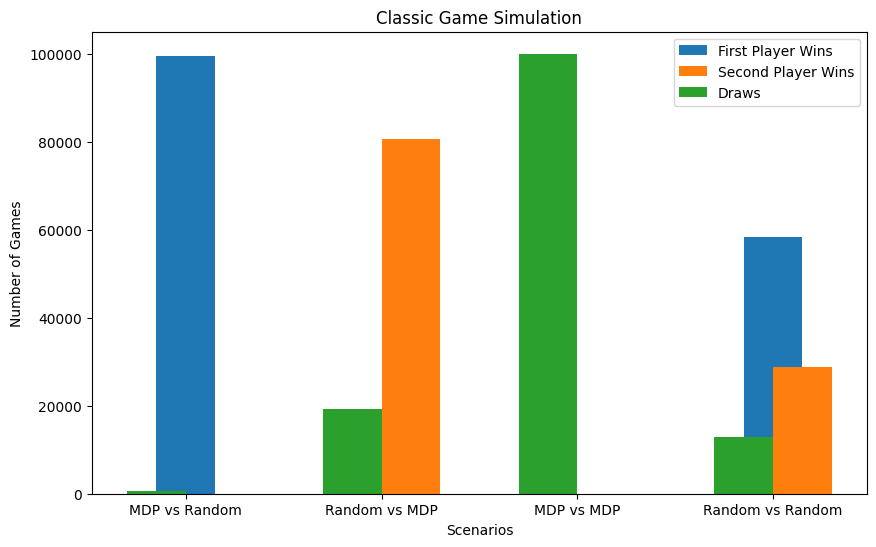

In [ ]:
simulate(classic_ba,100000,'Classic Game Simulation',Classic_P)

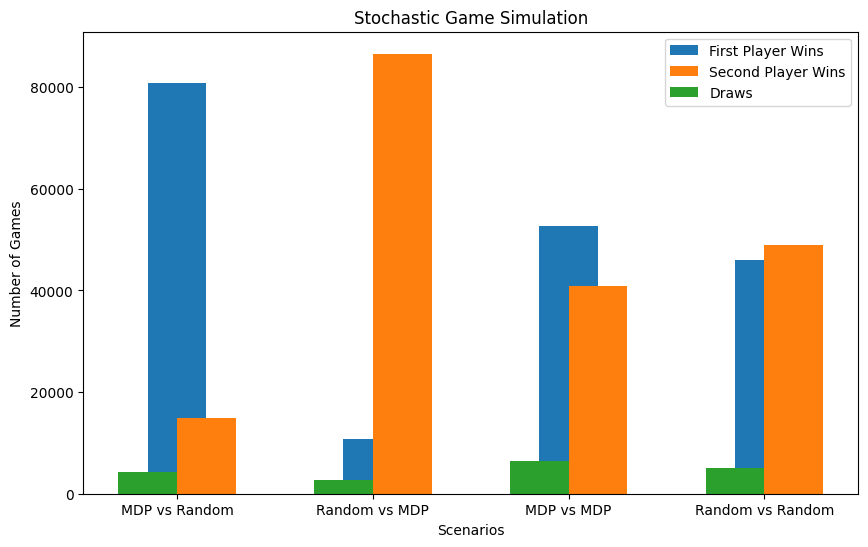

In [ ]:
simulate(stochastic_ba,100000,'Stochastic Game Simulation',Stochastic_P)

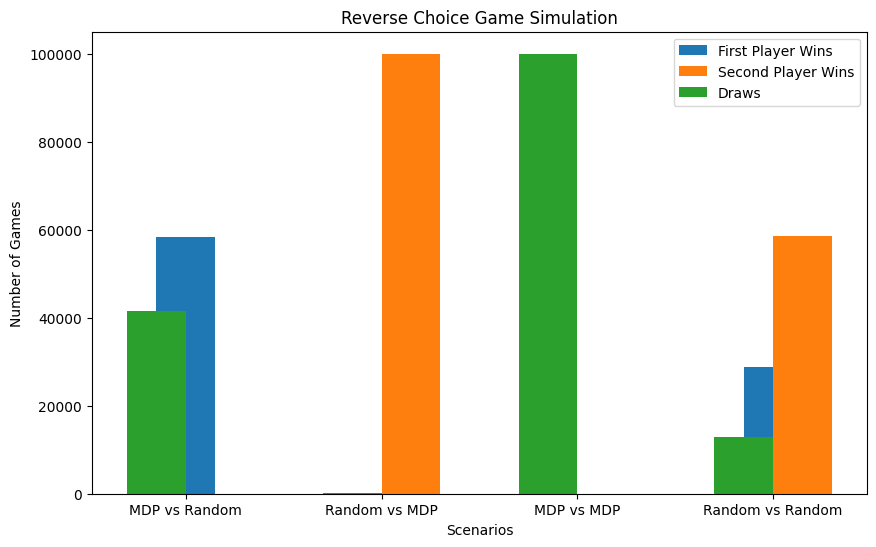

In [ ]:
simulate(reverse_ba,100000,'Reverse Choice Game Simulation',Reverse_P)

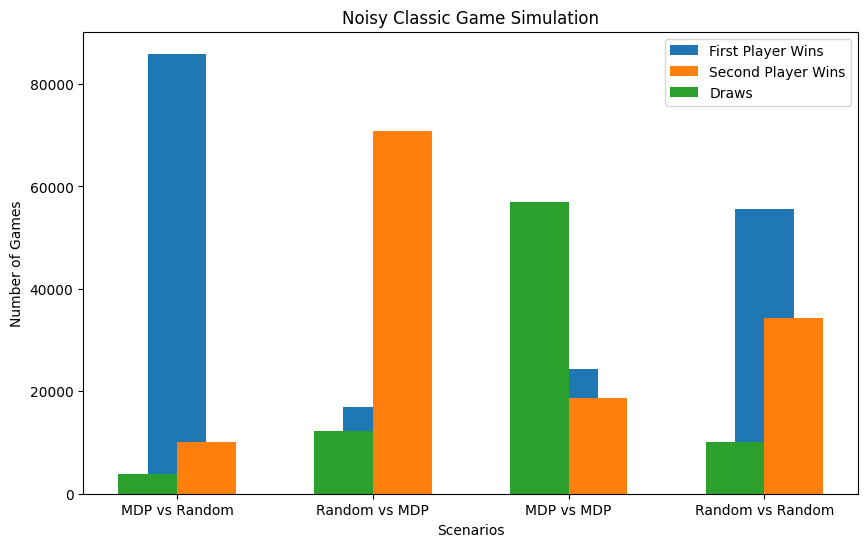

In [11]:
simulate(noisy_classic_ba,100000,'Noisy Classic Game Simulation',Noisy_classic_P)

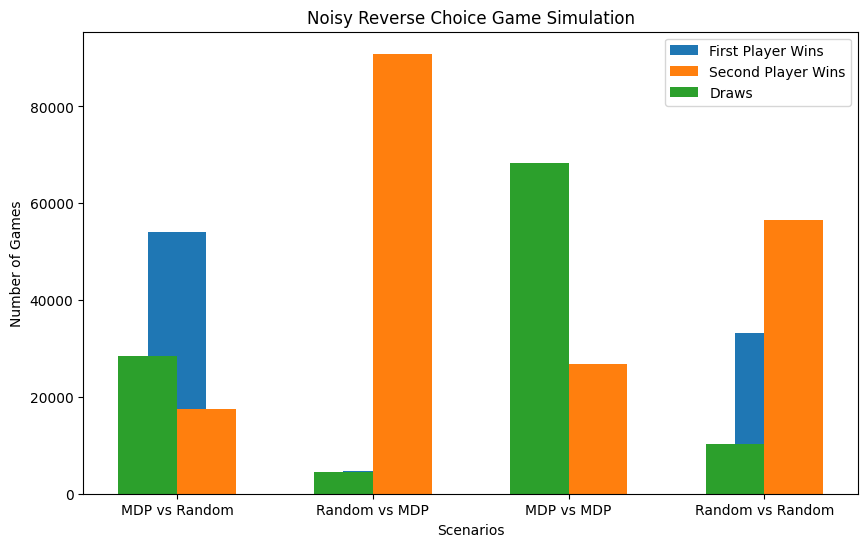

In [13]:
simulate(noisy_reverse_ba,100000,'Noisy Reverse Choice Game Simulation',Noisy_reverse_P)

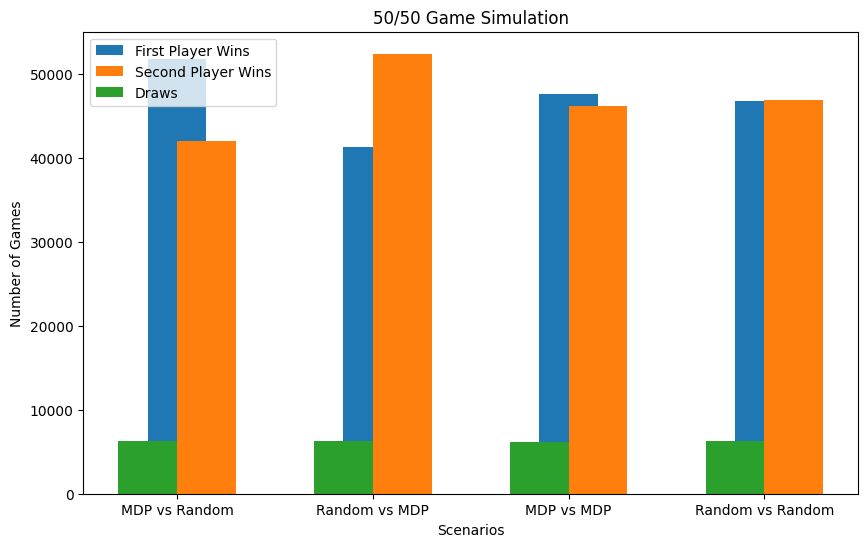

In [ ]:
simulate(half_ba,100000,'50/50 Game Simulation',Half_P)

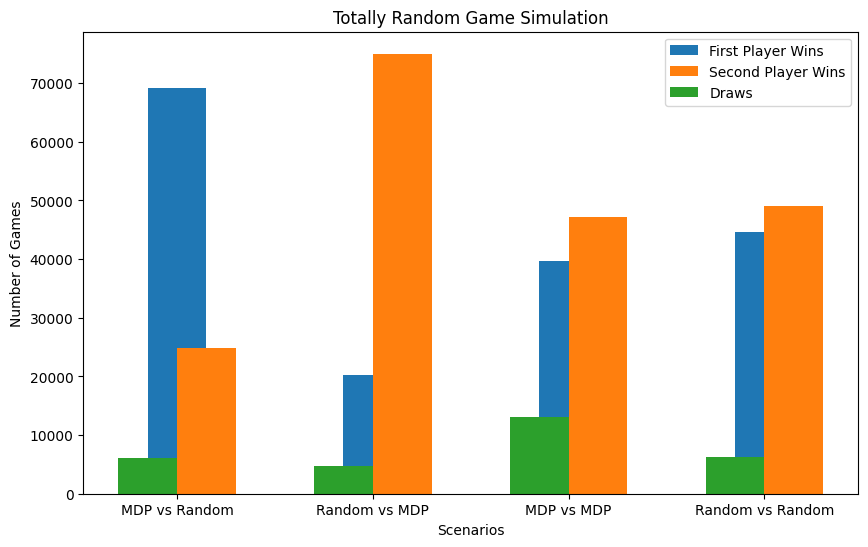

In [15]:
simulate(totally_random_ba,100000,'Totally Random Game Simulation',totally_random)

In [19]:

def simulate_two_trained_agents(agent_1, agent_2, num_games,P):
    agent_1_wins = 0
    agent_2_wins = 0
    draws = 0

    for _ in range(num_games):
        board = ['E'] * 9
        turn = 'X'

        while check_win(board) == 'Continue':
            if turn == 'X':
                action = agent_1[tuple(board), turn]

            else:
                action = agent_2[tuple(board), turn]

            if random.random()<P[action]:
              board[action] = next_turn(turn)
            else:
              board[action]=turn

            turn = next_turn(turn)

        result = check_win(board)
        if result == 'X':
            agent_1_wins += 1
        elif result == 'O':
            agent_2_wins += 1
        else:
            draws += 1

    return agent_1_wins, agent_2_wins, draws

def simulate_two_trained(ba1,ba2,num_games,game,P,label1,label2):

  # Scenario 1:  (Agent 1) starts first against (Agent 2)

  agent1_wins_1, agent2_wins_1, draws_1 = simulate_two_trained_agents(ba1,ba2, num_games,P)

  # Scenario 2:  (Agent 1) starts first (Agent 2)
  agent1_wins_2, agent2_wins_2, draws_2 = simulate_two_trained_agents(ba2, ba1, num_games,P)

  # Scenario 3: Two versions of  (Agent 1) play against each other
  agent1_wins_3, agent2_wins_3, draws_3 = simulate_two_trained_agents(ba1, ba1, num_games,P)

  # Scenario 4: Two versions of  (Agent 21) play against each other
  agent1_wins_4, agent2_wins_4, draws_4 = simulate_two_trained_agents(ba2, ba2, num_games,P)

  # Plot the results
  labels = [label1+' vs '+label2, label2+' vs '+label1, label1+' vs '+label1,label2+' vs '+label2]
  agent1_wins = [agent1_wins_1, agent1_wins_2, agent1_wins_3, agent1_wins_4]
  agent2_wins = [agent2_wins_1, agent2_wins_2, agent2_wins_3, agent2_wins_4]
  draws = [draws_1, draws_2, draws_3, draws_4]

  x = range(len(labels))

  plt.figure(figsize=(10, 6))
  plt.bar(x, agent1_wins, width=0.3, align='center', label='First Player Wins')
  plt.bar(x, agent2_wins, width=0.3, align='edge', label='Second Player Wins')
  plt.bar(x, draws, width=-0.3, align='edge', label='Draws')
  plt.xticks(x, labels)
  plt.xlabel('Scenarios')
  plt.ylabel('Number of Games')
  plt.title(game)
  plt.legend()
  plt.show()


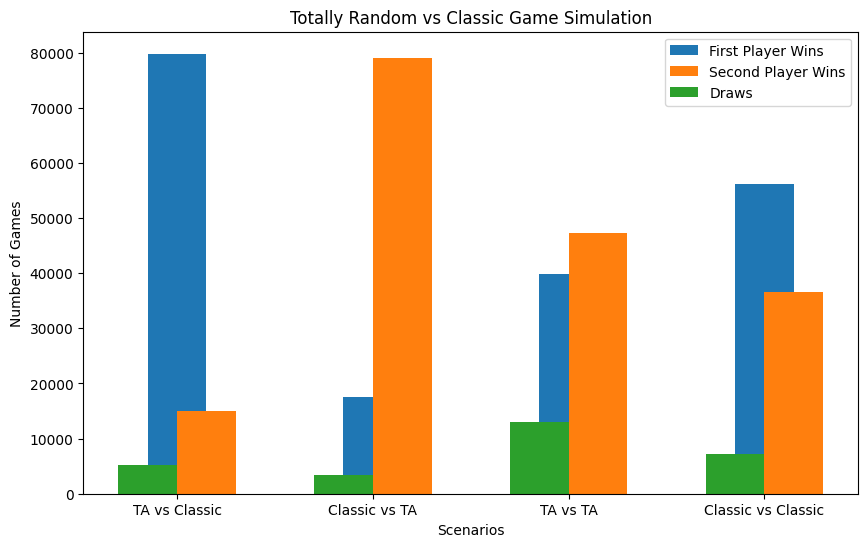

In [22]:
simulate_two_trained(totally_random_ba,classic_ba,100000,'Totally Random vs Classic Game Simulation',totally_random,"TA","Classic")

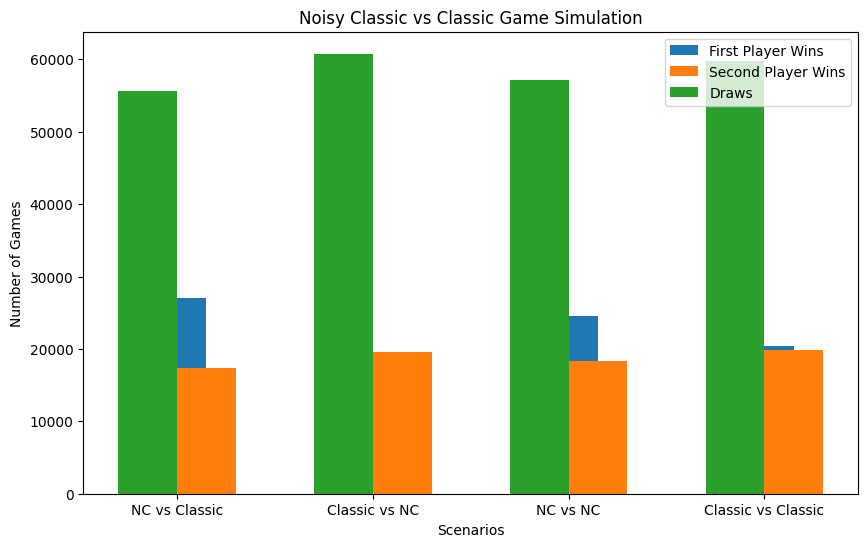

In [23]:
simulate_two_trained(noisy_classic_ba,classic_ba,100000,'Noisy Classic vs Classic Game Simulation',Noisy_classic_P,"NC","Classic")

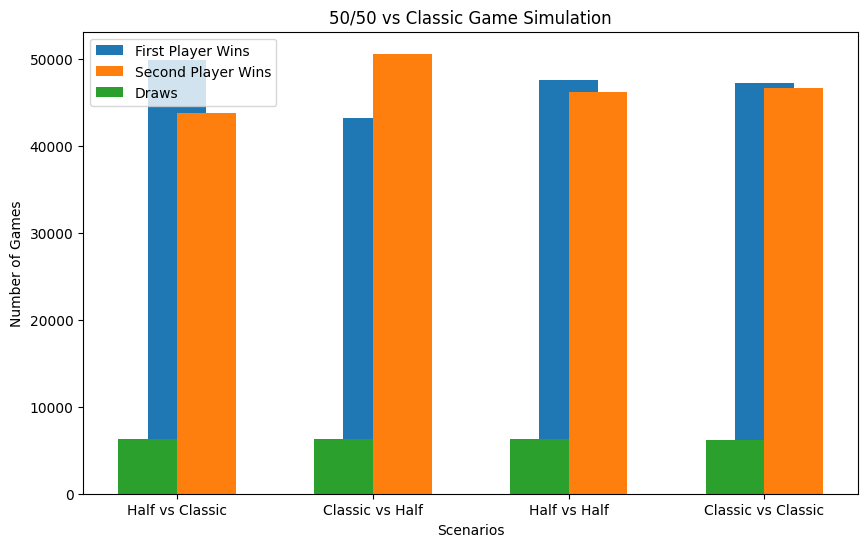

In [26]:
simulate_two_trained(half_ba,classic_ba,100000,'50/50 vs Classic Game Simulation',Half_P,"Half","Classic")

In [30]:
quarter_P=[0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

In [31]:
quarter_ba=find_value_function(quarter_P,'quarter.txt',10,states)



max diff:
0.75
max diff state:
(('X', 'X', 'O', 'X', 'X', 'O', 'O', 'E', 'E'), 'X')
average diff: 
0.4145407013431894


max diff:
0.75
max diff state:
(('X', 'X', 'O', 'O', 'X', 'X', 'E', 'E', 'E'), 'O')
average diff: 
0.19765843324619128


max diff:
0.609375
max diff state:
(('X', 'O', 'X', 'E', 'E', 'E', 'E', 'X', 'E'), 'X')
average diff: 
0.07335002929775535


max diff:
0.5546875
max diff state:
(('E', 'X', 'E', 'X', 'E', 'E', 'E', 'E', 'E'), 'O')
average diff: 
0.03482876307130623


max diff:
0.357421875
max diff state:
(('E', 'E', 'E', 'E', 'E', 'E', 'X', 'E', 'E'), 'X')
average diff: 
0.00992047701816461


max diff:
0.19775390625
max diff state:
(('E', 'E', 'E', 'X', 'E', 'X', 'E', 'E', 'E'), 'O')
average diff: 
0.0021974637017713873


max diff:
0.09869384765625
max diff state:
(('E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 'X')
average diff: 
0.0002769223306646083


max diff:
0.0711517333984375
max diff state:
(('E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 'X')
average diff:

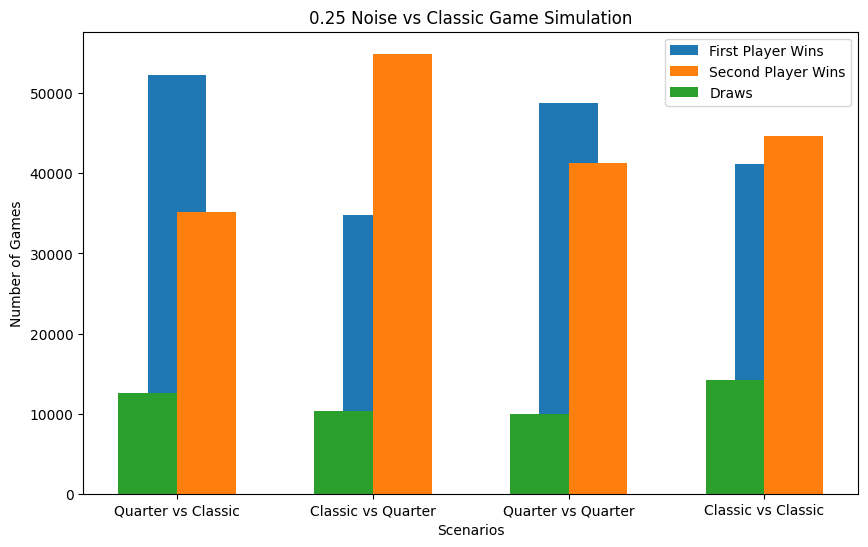

In [32]:
simulate_two_trained(quarter_ba,classic_ba,100000,'0.25 Noise vs Classic Game Simulation',quarter_P,"Quarter","Classic")

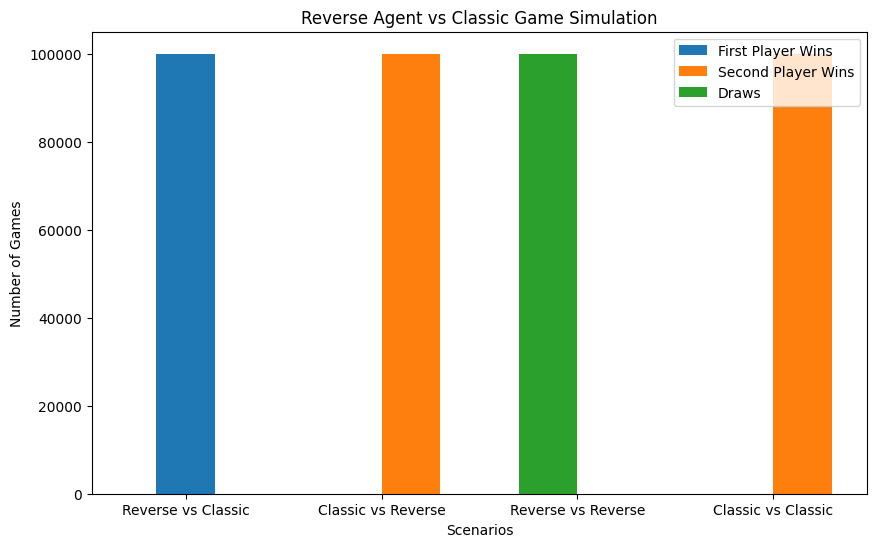

In [34]:
simulate_two_trained(reverse_ba,classic_ba,100000,'Reverse Agent vs Classic Game Simulation',Reverse_P,"Reverse","Classic")

In [35]:
def check_win_10x10(board):
    # The board is assumed to be a flat list of 100 elements
    if len(board) != 100:
        return "Invalid board size!"

    # Create a function to extract a sub-list for easier checking
    def extract_sublist(lst, start, end, step):
        return [lst[i] for i in range(start, end, step)]

    # Check rows
    for row in range(10):
        for col in range(6):  # Only need to check starting from columns 0 to 5 for 5 consecutive marks
            start_index = row * 10 + col
            sublist = extract_sublist(board, start_index, start_index + 5, 1)
            if len(set(sublist)) == 1 and sublist[0] != 'E':
                return sublist[0]

    # Check columns
    for col in range(10):
        for row in range(6):  # Only need to check starting from rows 0 to 5 for 5 consecutive marks
            start_index = row * 10 + col
            sublist = extract_sublist(board, start_index, start_index + 50, 10)
            if len(set(sublist)) == 1 and sublist[0] != 'E':
                return sublist[0]

    # Check main diagonals (from top-left to bottom-right)
    for row in range(6):
        for col in range(6):
            start_index = row * 10 + col
            sublist = extract_sublist(board, start_index, start_index + 55, 11)
            if len(set(sublist)) == 1 and sublist[0] != 'E':
                return sublist[0]

    # Check anti-diagonals (from top-right to bottom-left)
    for row in range(6):
        for col in range(4, 10):
            start_index = row * 10 + col
            sublist = extract_sublist(board, start_index, start_index + 45, 9)
            if len(set(sublist)) == 1 and sublist[0] != 'E':
                return sublist[0]

    # Check if the board is full (draw)
    if 'E' not in board:
        return 'Draw'

    # If no player has won and the board is not full, continue the game
    return 'Continue'

# Testing the function with some sample boards
sample_board1 = ['X']*40 + ['E']*60
sample_board2 = ['O', 'E', 'O', 'E', 'O', 'E', 'O', 'E', 'O', 'E'] * 10
sample_board3 = ['X', 'O', 'X', 'O', 'X', 'E', 'O', 'E', 'O', 'E'] * 10
sample_board4 = ['E']*100

check_win_10x10_results = {
    "sample_board1": check_win_10x10(sample_board1),
    "sample_board2": check_win_10x10(sample_board2),
    "sample_board3": check_win_10x10(sample_board3),
    "sample_board4": check_win_10x10(sample_board4)
}

check_win_10x10_results


{'sample_board1': 'X',
 'sample_board2': 'O',
 'sample_board3': 'X',
 'sample_board4': 'Continue'}

In [36]:
def board_printer_10x10(b):
    # Verify if the vector has the correct size
    if len(b) != 100:
        print("Invalid board size!")
        return

    c = []
    for i in range(100):
        if b[i] != 'E':
            c.append(b[i])
        else:
            c.append(' ')

    # Print the Tic Tac Toe board
    for row in range(10):
        row_data = c[row*10:row*10+10]
        print(" | ".join(row_data))
        if row < 9:
            print("---+---+---+---+---+---+---+---+---+---")

# Testing the board printer with the sample boards
print("Sample Board 1:")
board_printer_10x10(sample_board1)
print("\nSample Board 2:")
board_printer_10x10(sample_board2)
print("\nSample Board 3:")
board_printer_10x10(sample_board3)
print("\nSample Board 4:")
board_printer_10x10(sample_board4)


Sample Board 1:
X | X | X | X | X | X | X | X | X | X
---+---+---+---+---+---+---+---+---+---
X | X | X | X | X | X | X | X | X | X
---+---+---+---+---+---+---+---+---+---
X | X | X | X | X | X | X | X | X | X
---+---+---+---+---+---+---+---+---+---
X | X | X | X | X | X | X | X | X | X
---+---+---+---+---+---+---+---+---+---
  |   |   |   |   |   |   |   |   |  
---+---+---+---+---+---+---+---+---+---
  |   |   |   |   |   |   |   |   |  
---+---+---+---+---+---+---+---+---+---
  |   |   |   |   |   |   |   |   |  
---+---+---+---+---+---+---+---+---+---
  |   |   |   |   |   |   |   |   |  
---+---+---+---+---+---+---+---+---+---
  |   |   |   |   |   |   |   |   |  
---+---+---+---+---+---+---+---+---+---
  |   |   |   |   |   |   |   |   |  

Sample Board 2:
O |   | O |   | O |   | O |   | O |  
---+---+---+---+---+---+---+---+---+---
O |   | O |   | O |   | O |   | O |  
---+---+---+---+---+---+---+---+---+---
O |   | O |   | O |   | O |   | O |  
---+---+---+---+---+---+---+---+-

In [37]:
def next_turn_10x10(turn):
    # Toggles between the 'X' and 'O' players
    return 'O' if turn == 'X' else 'X'

def A_10x10(board, action):
    # Checks if an action is possible and legal on a board
    if board[action] != 'E':
        return False
    if check_win_10x10(board) != 'Continue':
        return False
    return True

def next_state_same_10x10(board, turn, action):
    # Returns a new board with the player's mark in the specified action
    new_board = board.copy()
    new_board[action] = turn
    return new_board

def next_state_reverse_10x10(board, turn, action):
    # Returns a new board with the opposite player's mark in the specified action
    new_turn = next_turn_10x10(turn)
    new_board = board.copy()
    new_board[action] = new_turn
    return new_board




In [39]:
def encode_state(board, turn):
    # Encoding the board
    encoded_board = []
    for cell in board:
        if cell == 'O':
            encoded_board.append(1)
        elif cell == 'X':
            encoded_board.append(3)
        else:  # cell is 'E'
            encoded_board.append(2)

    # Encoding the turn
    encoded_turn = -1 if turn == 'O' else 1

    # Combining the board encoding with the turn encoding
    encoded_state = encoded_board + [encoded_turn]

    return encoded_state

def evaluate_linear(parameters, state_vector):
    # Evaluating the linear function by taking the dot product of the parameters and the state_vector
    return sum(p*s for p, s in zip(parameters, state_vector))




In [46]:
def reward_10x10(board):
    # Check the result of the game using the check_win_10x10 function
    result = check_win_10x10(board)

    if result == 'X':
        return 1
    elif result == 'O':
        return -1
    else:
        return 0



In [55]:
import random

# Parameters
alpha =  0.0001  # learning rate
gamma = 1  # discount factor
lambd = 0.9  # decay factor for eligibility traces
num_episodes = 10000

# Initial parameters for linear value function
theta = [0.5] * 101

# Eligibility trace
e = [0] * 101

def choose_action(board, turn):
    # For now, we'll use a random policy
    valid_actions = [i for i, cell in enumerate(board) if cell == 'E']
    return random.choice(valid_actions)

# Cap on the number of moves per game to ensure games don't run indefinitely
max_moves_per_game = 1000

# Reset theta and eligibility trace for the new training loop
theta = [0.5] * 101
e = [0] * 101

def choose_action(board):
    # For now, we'll use a random policy
    valid_actions = [i for i, cell in enumerate(board) if cell == 'E']
    return random.choice(valid_actions)

for _ in range(num_episodes):
    # Start with an empty board and X's turn for a new game
    current_board = ['E'] * 100
    current_turn = 'X'
    moves = 0

    while check_win_10x10(current_board) == 'Continue' and moves < max_moves_per_game:
        # Choose action based on policy
        action = choose_action(current_board)

        # Apply the action and get new state
        new_board = next_state_same_10x10(current_board, current_turn, action)

        # Get reward for the new state
        r = reward_10x10(new_board)

        # Estimate value of current state and new state
        v_current = evaluate_linear(theta, encode_state(current_board, current_turn))
        v_new = evaluate_linear(theta, encode_state(new_board, next_turn_10x10(current_turn)))

        # TD error
        delta = r + gamma * v_new - v_current

        # Update eligibility trace
        e = [gamma * lambd * ei + 1 if encode_state(current_board, current_turn)[i] == 1 else gamma * lambd * ei for i, ei in enumerate(e)]

        # Update theta with the gradient (which is the feature value for linear function)
        features = encode_state(current_board, current_turn)
        theta = [theta_i + alpha * delta * e_i * feature for theta_i, e_i, feature in zip(theta, e, features)]

        # Update current state and turn for the next move
        current_board = new_board.copy()
        current_turn = next_turn_10x10(current_turn)
        moves += 1

print(theta) # Display updated parameters after the correction




KeyboardInterrupt: ignored

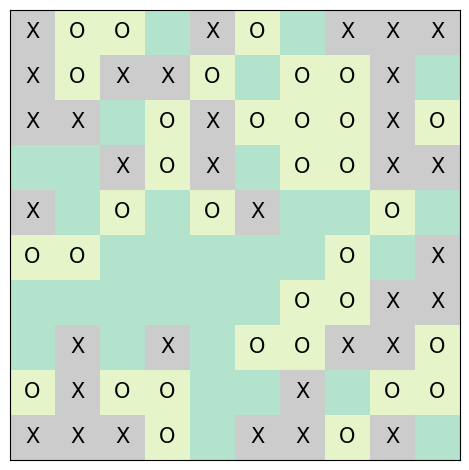

'X'

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# 1. Greedy Agent
def greedy_action(board, turn, theta):
    valid_actions = [i for i, cell in enumerate(board) if cell == 'E']
    values = []
    for action in valid_actions:
        next_board = next_state_same_10x10(board, turn, action)
        value = evaluate_linear(theta, encode_state(next_board, turn))
        values.append(value)
    best_action = valid_actions[np.argmax(values)]
    return best_action

# 2. Random Agent
def random_action(board):
    valid_actions = [i for i, cell in enumerate(board) if cell == 'E']
    return random.choice(valid_actions)

# For visualization, let's create a simple function to plot the board
def plot_board(board):
    # Map the board characters to distinct numeric values for visualization
    visual_board = [{'X': 2, 'O': 1, 'E': 0}[cell] for cell in board]
    reshaped_board = np.array(visual_board).reshape(10, 10)

    plt.imshow(reshaped_board, cmap="Pastel2")

    for i in range(10):
        for j in range(10):
            if board[i*10 + j] == 'X':
                plt.text(j, i, 'X', ha='center', va='center', color='black', fontsize=15)
            elif board[i*10 + j] == 'O':
                plt.text(j, i, 'O', ha='center', va='center', color='black', fontsize=15)

    plt.xticks([])
    plt.yticks([])
    plt.grid(True, which='both', linestyle='-', linewidth=2)
    plt.tight_layout()
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()


# 3. Simulate a game
def play_game(theta):
    board = ['E'] * 100
    turn = 'X'

    while check_win_10x10(board) == 'Continue':
        if turn == 'X':
            action = greedy_action(board, turn, theta)
        else:
            action = random_action(board)

        board = next_state_same_10x10(board, turn, action)
        plot_board(board)
        time.sleep(0.5)
        turn = next_turn_10x10(turn)

    return check_win_10x10(board)

# For demonstration purposes, we'll use the theta we got (even though it might not be well-trained).
result = play_game(theta)
result


In [84]:
def evaluate_2nd_degree_poly(parameters, state_vector):
    # Extract a and b_values from parameters
    a = parameters[:101]
    b_values = parameters[101:]

    # Compute the linear term
    linear_term = np.dot(a, state_vector)

    # Compute the quadratic term
    outer_product = np.outer(state_vector, state_vector)
    upper_triangle_indices = np.triu_indices(101)
    quadratic_values = outer_product[upper_triangle_indices]

    quadratic_term = np.dot(b_values, quadratic_values)

    return linear_term + quadratic_term

def gradient_2nd_degree_poly(parameters, state_vector):
    # For the linear terms, the gradient is just the state_vector
    linear_gradient = state_vector

    # For the quadratic terms, consider only the upper triangle for unique quadratic terms
    quadratic_gradient = np.triu(np.outer(state_vector, state_vector)).flatten()

    # Combine and return
    return np.concatenate([linear_gradient, quadratic_gradient])

def train_TD_lambda_2nd_degree(alpha, gamma, lambd, num_episodes, initial_parameters):
    # Parameters
    theta = initial_parameters  # The initial parameters for our value function
    e = [0] * len(initial_parameters)  # Eligibility trace
    max_moves_per_game = 200  # Cap on moves per game

    for _ in range(num_episodes):
        # Start with an empty board and X's turn for a new game
        current_board = ['E'] * 100
        current_turn = 'X'
        moves = 0

        while check_win_10x10(current_board) == 'Continue' and moves < max_moves_per_game:
            # Choose action based on policy
            action = choose_action(current_board)

            # Apply the action and get new state
            new_board = next_state_same_10x10(current_board, current_turn, action)

            # Get reward for the new state
            r = reward_10x10(new_board)

            # Estimate value of current state and new state using 2nd-degree polynomial
            v_current = evaluate_2nd_degree_poly(theta, encode_state(current_board, current_turn))
            v_new = evaluate_2nd_degree_poly(theta, encode_state(new_board, next_turn_10x10(current_turn)))

            # TD error
            delta = r + gamma * v_new - v_current
            print(delta)
            # Gradient of the value function
            grad = gradient_2nd_degree_poly(theta, encode_state(current_board, current_turn))

            # Update eligibility trace
            e = [gamma * lambd * ei + gi for ei, gi in zip(e, grad)]

            # Update theta using the TD error and gradient
            theta = [theta_i + alpha * delta * e_i for theta_i, e_i in zip(theta, e)]

            # Update current state and turn for the next move
            current_board = new_board.copy()
            current_turn = next_turn_10x10(current_turn)
            moves += 1

    return theta

# Display the functions


In [86]:
# Setting the parameters
alpha = 0.00001  # learning rate
gamma = 0.99999  # discount factor
lambd = 0.99  # decay factor for eligibility traces
num_episodes = 2000
initial_parameters = [0.5] * (101 + 5151)  # Initialize parameters

# Train the agent
trained_parameters = train_TD_lambda_2nd_degree(alpha, gamma, lambd, num_episodes, initial_parameters)

def greedy_action_2nd_degree(board, turn, parameters):
    possible_actions = [i for i, cell in enumerate(board) if cell == 'E']
    values = []

    for action in possible_actions:
        next_board = next_state_same_10x10(board, turn, action)
        state_vector = encode_state(next_board, turn)
        values.append(evaluate_2nd_degree_poly(parameters, state_vector))

    # Return the action that maximizes (for X) or minimizes (for O) the estimated value
    if turn == 'X':
        return possible_actions[np.argmax(values)]
    else:
        return possible_actions[np.argmin(values)]




Streaming output truncated to the last 5000 lines.
-2770.1336337508983
4156.090917397756
116.3434260917129
1947.9295093416877
4997.162441719556
-534.8866380468535
572.4277687384747
-3757.8073294441856
2567.8478532434456
1101.5168196412706
2387.58934866279
-2931.457824285899
2263.6368799154006
-725.4014247340965
3869.7713316654845
-3438.518390358775
2002.6018922316143
-3756.0855376138934
5026.638035423966
-2837.2742450495134
6751.651323742
-8803.731148390216
3052.8427115226223
-3579.8497856828035
-864.8155679592746
3955.483569281423
3752.5596787686227
-5753.673315287335
736.4701446862018
-2421.4847421836457
1784.9385751963418
-5194.197831444617
-3044.15032140362
2162.9011343636084
-594.9496075995557
-2742.5781953449477
2145.076545292861
-1721.4572266877221
2548.6140915341675
1770.0616245884157
-2585.2568602197134
-1426.0929842896294
1534.3180460192962
2286.8676119132433
949.1170403165161
-2543.0843846291828
1391.2004844518378
-533.5666079011426
-5405.863206806069
-7604.583193168044
-946

KeyboardInterrupt: ignored

In [74]:
print(trained_parameters)

[0.14641831339440037, -0.5660978272201285, -1.8100649955380568, 1.126200009592568, -0.30811020771412956, -1.1174940393421453, -1.1770361926297357, -1.3008670602416603, 0.2948158799809489, 0.01629090366707847, -1.2565876213773373, -0.20222613447271748, -2.463425371313392, 0.2936408781945131, -1.1982883245321805, -0.5993333193313718, -1.2286211795080055, 0.8228906052362814, -0.9339754690721308, -1.8839612271319213, 0.32838874222551395, -2.8067340097861706, -1.0494317676085925, 0.6857002415829585, -1.0734984781850603, -1.0484906080057657, -0.6258997747760067, -0.9545744954129389, -1.6596187250734187, -0.5634516283122073, -0.9280574634673896, -2.154633455368878, 0.16045032063325845, -0.7398836500648955, -0.4290080041241002, -0.6409904201933598, -1.4706445090547822, -1.0798814554251592, -1.3915911066129807, -0.6569226771705621, -0.7982508136177814, -0.9384508984649949, 0.3050074143031619, -1.104660891982083, 0.29169324336195296, -0.9375345905701833, -0.8067434386060781, -1.1778523849754157,

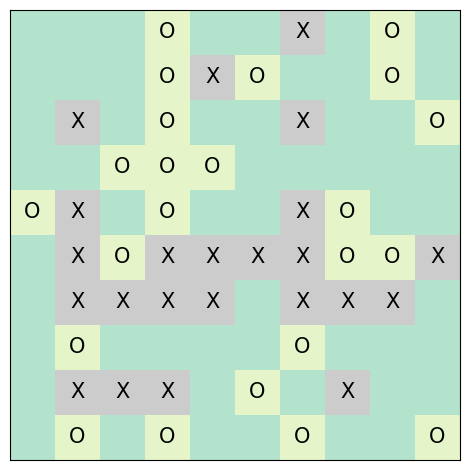

'O'

In [96]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Helper functions for the 10x10 board
# [check_win_10x10, board_printer_10x10, next_turn_10x10, A_10x10, next_state_same_10x10, next_state_reverse_10x10]

# Encoding the state into a numerical vector
def encode_state(board, turn):
    mapping = {'O': 1, 'X': 3, 'E': 2}
    encoded_board = [mapping[cell] for cell in board]
    turn_encoding = [-1] if turn == 'O' else [1]
    return np.array(encoded_board + turn_encoding)

# Evaluating the 2nd-degree polynomial
def evaluate_2nd_degree_poly(parameters, state_vector):
    linear_terms = parameters[:101] * state_vector
    quadratic_matrix = np.outer(state_vector, state_vector)
    upper_tri_indices = np.triu_indices(len(state_vector))
    unique_quadratic_terms = quadratic_matrix[upper_tri_indices]
    return np.sum(linear_terms) + np.dot(unique_quadratic_terms, parameters[101:])

# Gradient of the 2nd-degree polynomial
def gradient_2nd_degree_poly(state_vector):
    linear_gradient = state_vector
    quadratic_matrix = np.outer(state_vector, state_vector)
    upper_tri_indices = np.triu_indices(len(state_vector))
    quadratic_gradient = quadratic_matrix[upper_tri_indices]
    return np.concatenate([linear_gradient, quadratic_gradient])

# Reward structure
def reward_10x10(board):
    result = check_win_10x10(board)
    if result == 'X':
        return 1
    elif result == 'O':
        return -1
    else:
        return 0

# Training using TD-Learning for the 2nd-degree polynomial
def train_TD_2nd_degree(alpha, gamma, num_episodes, initial_parameters):
    theta = initial_parameters

    for i in range(num_episodes):
        current_board = ['E'] * 100
        current_turn = 'X'
        max_moves_per_game = 200
        moves = 0
        print("\n\n\n\n\n")
        print("starting game {}",i)
        print("\n\n\n\n\n")
        while check_win_10x10(current_board) == 'Continue' and moves < max_moves_per_game:
            action = random.choice([i for i, cell in enumerate(current_board) if cell == 'E'])
            new_board = next_state_same_10x10(current_board, current_turn, action)
            r = reward_10x10(new_board)
            v_current = evaluate_2nd_degree_poly(theta, encode_state(current_board, current_turn))
            v_new = evaluate_2nd_degree_poly(theta, encode_state(new_board, next_turn_10x10(current_turn)))
            delta = r + gamma * v_new - v_current
            print(delta)
            grad = gradient_2nd_degree_poly(encode_state(current_board, current_turn))
            theta += alpha * delta * grad
            current_board = new_board.copy()
            current_turn = next_turn_10x10(current_turn)
            moves += 1

    return theta

# Agent's action choice based on the 2nd-degree polynomial value function
def greedy_action(board, turn, parameters):
    valid_actions = [i for i, cell in enumerate(board) if cell == 'E']
    best_value = float('-inf')
    best_action = valid_actions[0]

    for action in valid_actions:
        potential_board = next_state_same_10x10(board, turn, action)
        state_vector = encode_state(potential_board, turn)
        value = evaluate_2nd_degree_poly(parameters, state_vector)
        if value > best_value:
            best_value = value
            best_action = action

    return best_action

# Visualizing the board
def plot_board(board):
    visual_board = [{'X': 2, 'O': 1, 'E': 0}[cell] for cell in board]
    reshaped_board = np.array(visual_board).reshape(10, 10)
    plt.imshow(reshaped_board, cmap="Pastel2")

    for i in range(10):
        for j in range(10):
            if board[i*10 + j] == 'X':
                plt.text(j, i, 'X', ha='center', va='center', color='black', fontsize=15)
            elif board[i*10 + j] == 'O':
                plt.text(j, i, 'O', ha='center', va='center', color='black', fontsize=15)

    plt.xticks([])
    plt.yticks([])
    plt.grid(True, which='both', linestyle='-', linewidth=2)
    plt.tight_layout()
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()

# Simulate a game against a random opponent
def play_game(parameters):
    board = ['E'] * 100
    turn = 'X'

    while check_win_10x10(board) == 'Continue':
        if turn == 'X':
            action = greedy_action(board, turn, parameters)
        else:
            action = random.choice([i for i, cell in enumerate(board) if cell == 'E'])

        board[action] = turn
        plot_board(board)
        turn = next_turn_10x10(turn)

    return check_win_10x10(board)

# Set the parameters and train
alpha = 0.00001
gamma = 0.9999
num_episodes = 3000
initial_parameters = [0.5] * (101 + 5151)
trained_parameters = train_TD_2nd_degree(alpha, gamma, num_episodes, initial_parameters)

# Play the game
result = play_game(trained_parameters)
result


KeyboardInterrupt: ignored

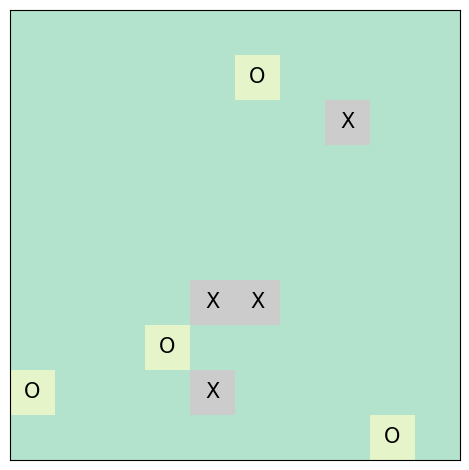

In [93]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
# Define the greedy action selection based on 2nd degree polynomial approximation
def greedy_action_2nd_degree_poly(board, turn, parameters):
    possible_actions = [i for i, cell in enumerate(board) if cell == 'E']
    values = []

    for action in possible_actions:
        next_board = next_state_same_10x10(board, turn, action)
        state_vector = encode_state(next_board, turn)
        values.append(evaluate_2nd_degree_poly(parameters, state_vector))

    # Return the action that maximizes (for X) or minimizes (for O) the estimated value
    if turn == 'X':
        return possible_actions[np.argmax(values)]
    else:
        return possible_actions[np.argmin(values)]

# Define random action selection for the opponent
def random_action(board):
    return random.choice([i for i, cell in enumerate(board) if cell == 'E'])

# Simulate a game
def play_game_2nd_degree(parameters):
    board = ['E'] * 100
    turn = 'X'

    while check_win_10x10(board) == 'Continue':
        if turn == 'X':
            action = greedy_action_2nd_degree_poly(board, turn, parameters)
        else:
            action = random_action(board)

        board = next_state_same_10x10(board, turn, action)
        plot_board(board)
        time.sleep(0.5)
        turn = next_turn_10x10(turn)

    return check_win_10x10(board)

# Play the game using the provided functions
result = play_game_2nd_degree(trained_parameters)
result


In [97]:
def simulate_games(parameters, num_games=100):
    results = {"X": 0, "O": 0, "Draw": 0}

    for i in range(num_games):
        board = ['E'] * 100
        turn = 'X'

        while check_win_10x10(board) == 'Continue':
            print(i)
            if turn == 'X':
                action = greedy_action_2nd_degree_poly(board, turn, parameters)
            else:
                action = random_action(board)

            board = next_state_same_10x10(board, turn, action)
            turn = next_turn_10x10(turn)

        game_result = check_win_10x10(board)
        results[game_result] += 1

    return results

# Simulate 1000 games
simulation_results = simulate_games(trained_parameters)
simulation_results


Streaming output truncated to the last 5000 lines.
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
2

{'X': 67, 'O': 33, 'Draw': 0}

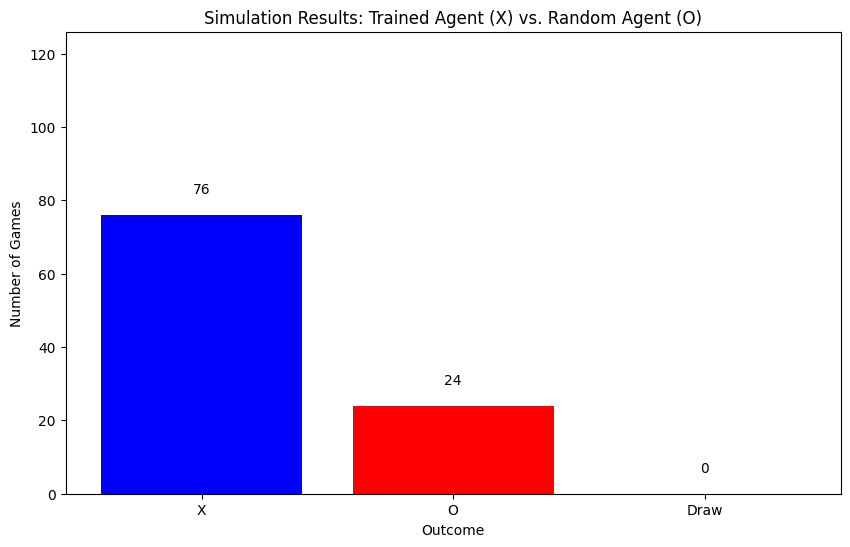

In [79]:
import matplotlib.pyplot as plt

def plot_simulation_results(results):
    labels = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'red', 'gray'])

    for i, v in enumerate(values):
        plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)

    plt.xlabel('Outcome')
    plt.ylabel('Number of Games')
    plt.title('Simulation Results: Trained Agent (X) vs. Random Agent (O)')
    plt.ylim(0, max(values) + 50)
    plt.show()

plot_simulation_results(simulation_results)
